In [57]:
# Import required dependencies
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
import pandas as pd

# Add the parent directory to sys.path
parent_dir = os.path.abspath("..")
sys.path.insert(0, parent_dir)

# Configure matplotlib
plt.rcParams.update({
    "pgf.texsystem": "pdflatex",
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
})

# constants
FIGURE_SAVE_LOCATION = "../data/figures/05evaluate/"
FIGURE_PREFILE = "outer_"

In [58]:
# Load batch data

batch_dir = "../data/outer/batch"
batch_data = {}

# for each folder in the batch directory
for folder in os.listdir(batch_dir):
    folder_path = os.path.join(batch_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": folder_name_parts[0],
            "iteration": folder_name_parts[1],
            "runs": folder_name_parts[2],
            "timestamps_data": {},
            "trial_data": {}
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the batch_data dictionary
        batch_data[folder] = data

In [59]:
# print root elements of batch_data
for key, value in batch_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

8_20_10: 8, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

16_20_10: 16, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

2_20_10: 2, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

4_20_10: 4, 20, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



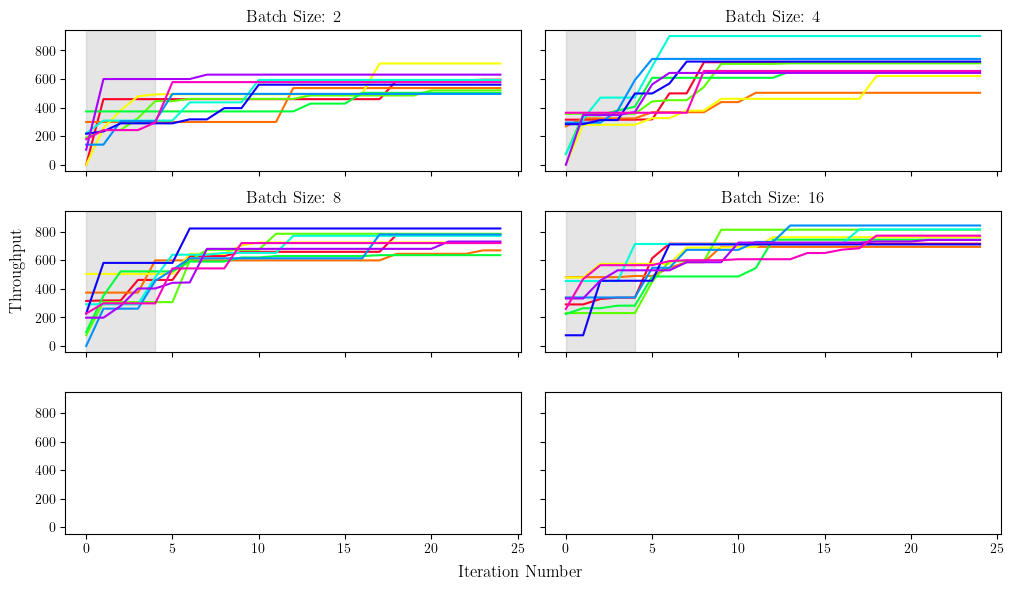

In [60]:
# Plot each batch in a separate subplot (each trial)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

# Create a 2x2 subplot
fig, axes = plt.subplots(3, 2, figsize=(10, 6), sharex=True, sharey=True)

# sort the batch_data by int
batch_data = dict(sorted(batch_data.items(), key=lambda item: int(item[1]['batch'])))

for i, (batch_name, data) in enumerate(batch_data.items()):
    ax = axes[i // 2, i % 2]

    # For each trial in trial_data, plot the max‐per‐trial throughput for each run
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        ax.plot(
            best_per_trial["trial_index"],
            best_per_trial["inv_rho_inc"],
            label=trial_name
        )
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0.0, 4.0, color='gray', alpha=0.2, label='Warm Start (Trials 0–4)')


# Add shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch.pdf", bbox_inches='tight')

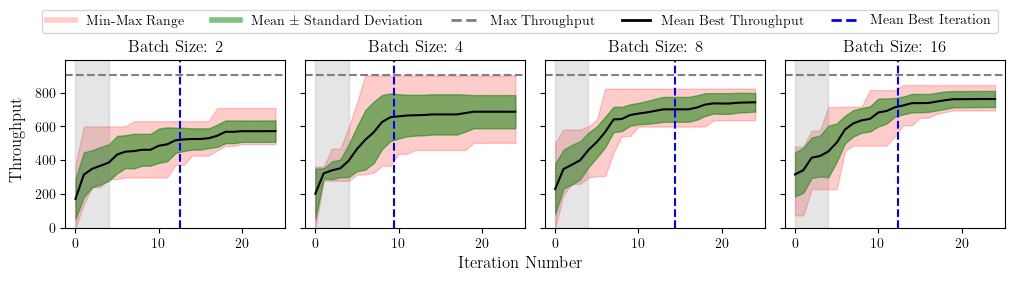

In [88]:
# Plot each batch in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the batch_data by batch size
batch_data = dict(sorted(batch_data.items(), key=lambda item: int(item[1]['batch'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (batch_name, data) in enumerate(batch_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes.flat:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch_error_area.pdf", bbox_inches='tight')

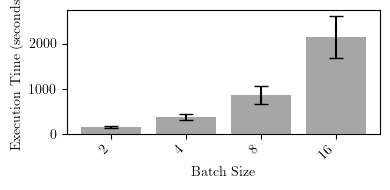

In [104]:
# Plot time deltas for each batch

# for each batch
batch_deltas = {}
for i, (batch_name, data) in enumerate(batch_data.items()):
    
    # for each trial extract the iteration number with the best throughput
    deltas = []
    for trial_name, trial_df in data["trial_data"].items():
        # start is index 0 and end is index -1
        start_time = data["timestamps_data"][trial_name].iloc[0]["timestamp"]
        end_time = data["timestamps_data"][trial_name].iloc[-1]["timestamp"]

        # convert to datetime and calculate the delta
        delta = pd.to_datetime(end_time) - pd.to_datetime(start_time)
        deltas.append(delta.total_seconds())

    # store the deltas in the batch_deltas dictionary
    batch_deltas[batch_name] = {
        "batch": data["batch"],
        "iteration": data["iteration"],
        "runs": data["runs"],
        "deltas": deltas
    }

# plot a bar chart of the deltas with error bars
fig, ax = plt.subplots(figsize=(4, 2))

# sort the batch_deltas by batch size (as integer)
batch_deltas = dict(sorted(batch_deltas.items(), key=lambda item: int(item[1]['batch'])))

# create a DataFrame from the batch_deltas
df_deltas = pd.DataFrame.from_dict(batch_deltas, orient='index')

# prepare x positions and labels
x = np.arange(len(df_deltas))
batch_sizes = df_deltas['batch']

# compute mean and std of deltas
means = df_deltas['deltas'].apply(np.mean)
errors = df_deltas['deltas'].apply(np.std)

# plot the bars
ax.bar(x, means, yerr=errors, capsize=5, color='gray', alpha=0.7)

# set axis labels and ticks to batch sizes
ax.set_xlabel("Batch Size")
ax.set_ylabel("Execution Time (seconds)")
ax.set_xticks(x)
ax.set_xticklabels(batch_sizes, rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch_deltas.pdf", bbox_inches='tight')


In [66]:
# Load skew data

skew_dir = "../data/outer/skew"
skew_data = {}

# for each folder in the batch directory
for folder in os.listdir(skew_dir):
    folder_path = os.path.join(skew_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 8,
            "iteration": 20,
            "runs": 10,
            "timestamps_data": {},
            "trial_data": {},
            "skew_range": (float(folder_name_parts[1]), float(folder_name_parts[2]))
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the skew_data dictionary
        skew_data[folder] = data

In [67]:
# Print root elements of skew_data
for key, value in skew_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, Skew Range: {value['skew_range']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

skew_-3.0_3.0: 8, 20, 10, Skew Range: (-3.0, 3.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

skew_-5.0_5.0: 8, 20, 10, Skew Range: (-5.0, 5.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

skew_-1.0_1.0: 8, 20, 10, Skew Range: (-1.0, 1.0)
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



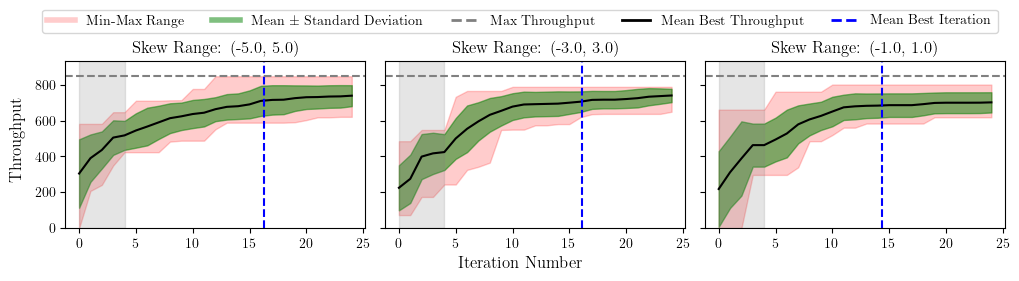

In [68]:
# Plot each skew in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the skew_data by the lower bound of skew_range
skew_data = dict(sorted(skew_data.items(), key=lambda item: item[1]['skew_range'][0]))

max_rho = 0.0

for i, (name, data) in enumerate(skew_data.items()):
    ax = axes[i]

    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current max is greater
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')

    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )

    ax.set_title(f"Skew Range: {data['skew_range']}")
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)

# shared axis labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}skew_error_area.pdf", bbox_inches='tight')


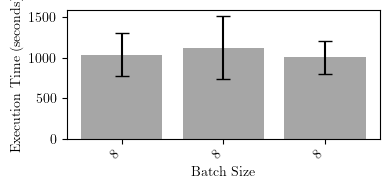

In [105]:
# Plot time deltas for each batch

# for each batch
skew_deltas = {}
for i, (batch_name, data) in enumerate(skew_data.items()):
    
    # for each trial extract the iteration number with the best throughput
    deltas = []
    for trial_name, trial_df in data["trial_data"].items():
        # start is index 0 and end is index -1
        start_time = data["timestamps_data"][trial_name].iloc[0]["timestamp"]
        end_time = data["timestamps_data"][trial_name].iloc[-1]["timestamp"]

        # convert to datetime and calculate the delta
        delta = pd.to_datetime(end_time) - pd.to_datetime(start_time)
        deltas.append(delta.total_seconds())

    # store the deltas in the skew_deltas dictionary
    skew_deltas[batch_name] = {
        "batch": data["batch"],
        "iteration": data["iteration"],
        "runs": data["runs"],
        "deltas": deltas
    }

# plot a bar chart of the deltas with error bars
fig, ax = plt.subplots(figsize=(4, 2))

# sort the skew_deltas by batch size (as integer)
skew_deltas = dict(sorted(skew_deltas.items(), key=lambda item: int(item[1]['batch'])))

# create a DataFrame from the skew_deltas
df_deltas = pd.DataFrame.from_dict(skew_deltas, orient='index')

# prepare x positions and labels
x = np.arange(len(df_deltas))
batch_sizes = df_deltas['batch']

# compute mean and std of deltas
means = df_deltas['deltas'].apply(np.mean)
errors = df_deltas['deltas'].apply(np.std)

# plot the bars
ax.bar(x, means, yerr=errors, capsize=5, color='gray', alpha=0.7)

# set axis labels and ticks to batch sizes
ax.set_xlabel("Batch Size")
ax.set_ylabel("Execution Time (seconds)")
ax.set_xticks(x)
ax.set_xticklabels(batch_sizes, rotation=45, ha='right')

plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}skew_deltas.pdf", bbox_inches='tight')


In [69]:
# Load skew data
island_dir = "../data/outer/island"
island_data = {}

# for each folder in the batch directory
for folder in os.listdir(island_dir):
    folder_path = os.path.join(island_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 8,
            "iteration": 20,
            "runs": 10,
            "timestamps_data": {},
            "trial_data": {},
            "num_islands": int(folder_name_parts[3]),
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the island_data dictionary
        island_data[folder] = data

In [70]:
# Print root elements of island_data
for key, value in island_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, Num Islands: {value['num_islands']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

min_island_size_4: 8, 20, 10, Num Islands: 4
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

min_island_size_2: 8, 20, 10, Num Islands: 2
Timestamps data: ['4', '3', '2', '5', '1', '6']
Trial data: ['6', '4', '5', '1', '2', '3']

min_island_size_16: 8, 20, 10, Num Islands: 16
Timestamps data: ['4', '3', '2', '5', '1', '6']
Trial data: ['6', '4', '5', '1', '2', '3']

min_island_size_8: 8, 20, 10, Num Islands: 8
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



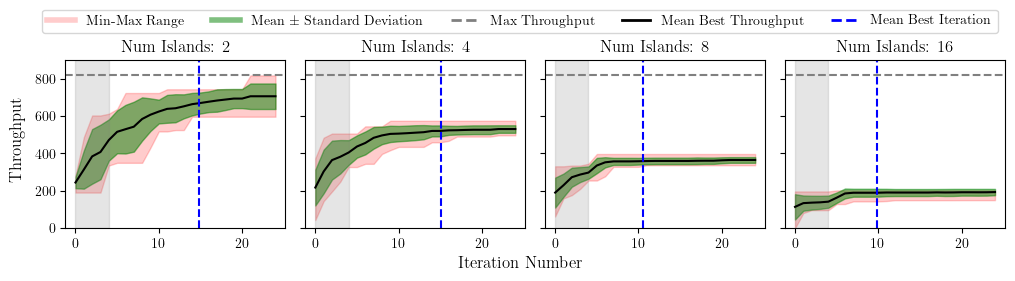

In [71]:
# Plot each island in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the island_data by num_islands
island_data = dict(sorted(island_data.items(), key=lambda item: item[1]['num_islands']))

max_rho = 0.0

for i, (name, data) in enumerate(island_data.items()):
    ax = axes[i]

    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current max is greater
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')

    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )

    ax.set_title(f"Num Islands: {data['num_islands']}")
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes.flat:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)

# shared axis labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}island_error_area.pdf", bbox_inches='tight')

In [72]:
# Load azure_conv_dir
azure_conv_dir = "../data/outer/azure-conv"
azure_conv_data = {}

# for each folder in the batch directory
index = 0
for folder in os.listdir(azure_conv_dir):
    folder_path = os.path.join(azure_conv_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 8,
            "iteration": 15,
            "runs": 10,
            "timestamps_data": {},
            "trial_data": {},
            "inventory": {},
        }

        # extract inventory from the folder name (azure_conv_{'_'.join(f'{k}-{v}' for k, v in inventory.items())})
        inventory = {}
        for part in folder_name_parts[2:]:
            # if more than one dash, split by the second dash
            if part.count('-') == 2:
                key, key2, value = part.split('-')
                inventory[f"{key}-{key2}"] = value
            else:
                key, value = part.split('-')
                inventory[key] = value
        data["inventory"] = inventory

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the azure_conv_data dictionary
        azure_conv_data[folder] = data

In [73]:
# print root elements of azure_conv_data
for key, value in azure_conv_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

azure_conv_GB300-NVL72-64_H800-128: 8, 15, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

azure_conv_DGX-B300-64_GB300-NVL72-64_H200-256_H800-128_H20-256: 8, 15, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

azure_conv_DGX-B300-64_GB300-NVL72-32_H800-16: 8, 15, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

azure_conv_H20-128_H200-128: 8, 15, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']

azure_conv_DGX-B300-128_H200-256: 8, 15, 10
Timestamps data: ['4', '3', '2', '5', '7', '8', '9', '1', '6', '10']
Trial data: ['7', '6', '4', '5', '1', '2', '3', '10', '8', '9']



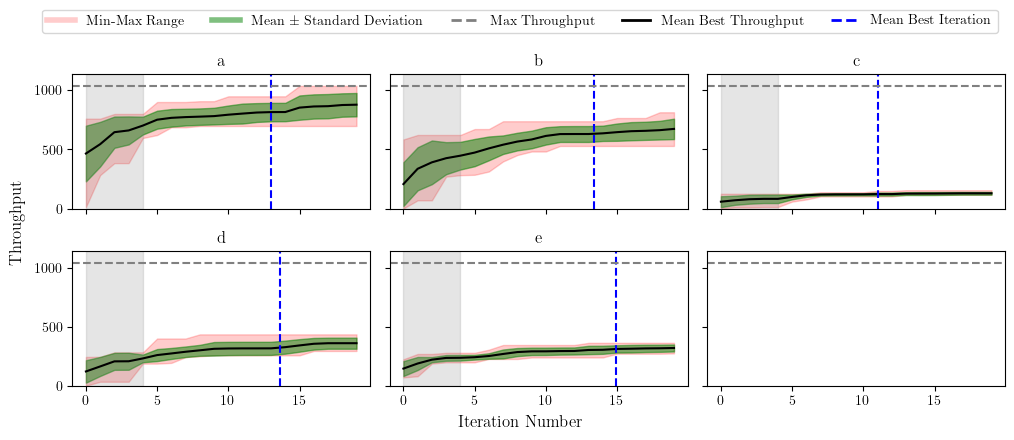

In [74]:
# Plot each azure conv in a separate subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))
fig, axes = plt.subplots(2, 3, figsize=(10, 4), sharex=True, sharey=True)

# sort the azure_conv_data by highest number of value sum in inventory
azure_conv_data = dict(sorted(azure_conv_data.items(), key=lambda item: sum(int(v) for v in item[1]['inventory'].values()), reverse=True))

max_rho = 0.0

for i, (name, data) in enumerate(azure_conv_data.items()):
    ax = axes[i // 3, i % 3]

    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current max is greater
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')

    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )

    # put a/b/c in the title then i will include a table for the inventory
    ax.set_title(chr(ord('a') + i))
    ax.axvspan(0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes.flat:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)

# shared axis labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}azure_conv_error_area.pdf", bbox_inches='tight')

In [75]:
# Load old saasbo data

old_saasbo_dir = "../data/outer/old-saasbo"
old_saasbo_data = {}

# for each folder in the batch directory
for folder in os.listdir(old_saasbo_dir):
    folder_path = os.path.join(old_saasbo_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": folder_name_parts[1],
            "iteration": folder_name_parts[2],
            "runs": folder_name_parts[3],
            "timestamps_data": {},
            "trial_data": {}
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the old_saasbo_data dictionary
        old_saasbo_data[folder] = data

In [76]:
# print root elements of old_saasbo_data
for key, value in old_saasbo_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

saasbo_8_10_5: 8, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_4_10_5: 4, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_2_10_5: 2, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']



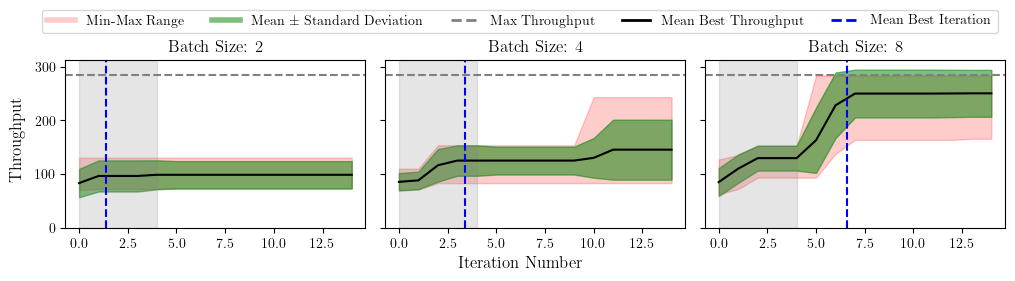

In [77]:
# Plot each old_saasbo_data in a subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

# Create a subplot
fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the old_saasbo_data by int
old_saasbo_data = dict(sorted(old_saasbo_data.items(), key=lambda item: int(item[1]['batch'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (batch_name, data) in enumerate(old_saasbo_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0.0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_error_area.pdf", bbox_inches='tight')

  4: No timestamp found for best iteration 4
  5: No timestamp found for best iteration 1
  1: No timestamp found for best iteration 1
  2: No timestamp found for best iteration 1
  4: No timestamp found for best iteration 2
  5: No timestamp found for best iteration 3
  3: No timestamp found for best iteration 2


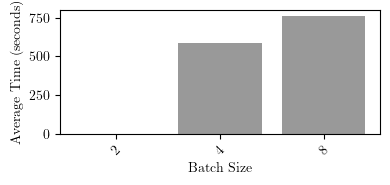

In [78]:
# Plot time deltas for each batch

# for each batch
batch_deltas = {}
for i, (batch_name, data) in enumerate(old_saasbo_data.items()):
    
    # for each trial extract the iteration number with the best throughput
    best_iterations = {}
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        # get the iteration number with the best throughput
        best_iteration = best_per_trial.loc[best_per_trial['inv_rho_inc'].idxmax(), 'trial_index']
        best_iterations[trial_name] = best_iteration

    # extract the timestamps for the best iteration
    timestamps_df = data["timestamps_data"]

    deltas = []
    for trial_name, best_iteration in best_iterations.items():
        end_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == best_iteration, 'timestamp']
        start_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == 0, 'timestamp']

        if end_timestamp.empty or start_timestamp.empty:
            print(f"  {trial_name}: No timestamp found for best iteration {best_iteration}")
            continue
        
        delta = pd.to_datetime(end_timestamp.values[0]) - pd.to_datetime(start_timestamp.values[0])
        deltas.append(delta.total_seconds())

    # add the deltas to the batch_deltas list
    batch_deltas[batch_name] = {
        "deltas": deltas,
        "average": np.mean(deltas),
        "batch_size": data['batch'],
    }

# plot a bar chart of the deltas (average time taken for each batch)
plt.figure(figsize=(4, 2))
plt.bar([d['batch_size'] for d in batch_deltas.values()], [d['average'] for d in batch_deltas.values()], color='black', alpha=0.4)
plt.xlabel('Batch Size')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_deltas.pdf", bbox_inches='tight')

In [79]:
# Load saasbo kslots data

old_saasbo_kslots_dir = "../data/outer/old-saasbo-kslots"
old_saasbo_kslots_data = {}

# for each folder in the batch directory
for folder in os.listdir(old_saasbo_kslots_dir):
    folder_path = os.path.join(old_saasbo_kslots_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": 4,
            "iteration": 10,
            "runs": 5,
            "timestamps_data": {},
            "trial_data": {},
            "kslots": folder_name_parts[3],
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the old_saasbo_data dictionary
        old_saasbo_kslots_data[folder] = data

In [80]:
# print root elements of old_saasbo_kslots_data
for key, value in old_saasbo_kslots_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}, {value['kslots']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

saasbo_k_slots_16: 4, 10, 5, 16
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_k_slots_32: 4, 10, 5, 32
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

saasbo_k_slots_8: 4, 10, 5, 8
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']



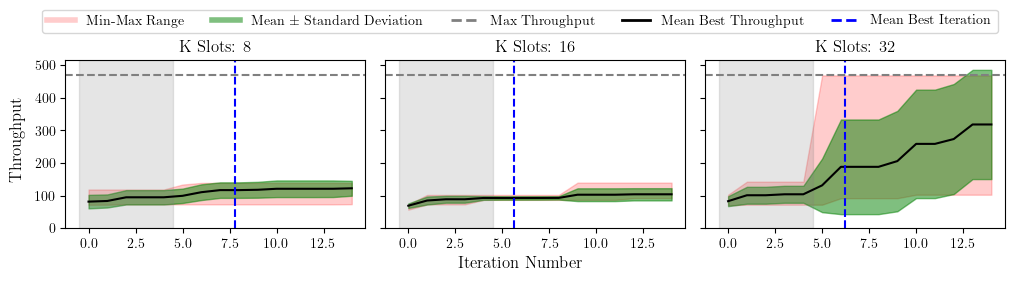

In [81]:
# Plot each kslots in a subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

fig, axes = plt.subplots(1, 3, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the old_saasbo_kslots_data by kslots
old_saasbo_kslots_data = dict(sorted(old_saasbo_kslots_data.items(), key=lambda item: int(item[1]['kslots'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (name, data) in enumerate(old_saasbo_kslots_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"K Slots: {data['kslots']}")

    # Shade warmup trials 0-4
    ax.axvspan(-0.5, 4.5, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))


plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_kslots_error_area.pdf", bbox_inches='tight')

  5: No timestamp found for best iteration 2
  2: No timestamp found for best iteration 4
  3: No timestamp found for best iteration 1


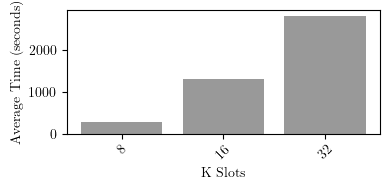

In [82]:
# Plot time deltas for each kslots

# for each kslots
kslots_deltas = {}

for i, (name, data) in enumerate(old_saasbo_kslots_data.items()):
    # for each trial extract the iteration number with the best throughput
    best_iterations = {}
    for trial_name, trial_df in data["trial_data"].items():
        # extract the trial index from the trial_df
        best_per_trial = (
            trial_df
            .groupby("trial_index")["inv_rho_inc"]
            .max()
            .reset_index()
        )
        # get the iteration number with the best throughput
        best_iteration = best_per_trial.loc[best_per_trial['inv_rho_inc'].idxmax(), 'trial_index']
        best_iterations[trial_name] = best_iteration

    # extract the timestamps for the best iteration
    timestamps_df = data["timestamps_data"]

    deltas = []
    for trial_name, best_iteration in best_iterations.items():
        end_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == best_iteration, 'timestamp']
        start_timestamp = timestamps_df[trial_name].loc[timestamps_df[trial_name]['trial index'] == 0, 'timestamp']

        if end_timestamp.empty or start_timestamp.empty:
            print(f"  {trial_name}: No timestamp found for best iteration {best_iteration}")
            continue
        
        delta = pd.to_datetime(end_timestamp.values[0]) - pd.to_datetime(start_timestamp.values[0])
        deltas.append(delta.total_seconds())

    # add the deltas to the kslots_deltas list
    kslots_deltas[name] = {
        "deltas": deltas,
        "average": np.mean(deltas),
        "kslots": data['kslots'],
    }
    
# plot a bar chart of the deltas (average time taken for each kslots)
plt.figure(figsize=(4, 2))
plt.bar([d['kslots'] for d in kslots_deltas.values()], [d['average'] for d in kslots_deltas.values()], color='black', alpha=0.4)
plt.xlabel('K Slots')
plt.ylabel('Average Time (seconds)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_saasbo_kslots_deltas.pdf", bbox_inches='tight')

In [83]:
# Load old bo data

old_bo_dir = "../data/outer/old-bo"
old_bo_data = {}

# for each folder in the batch directory
for folder in os.listdir(old_bo_dir):
    folder_path = os.path.join(old_bo_dir, folder)
    if os.path.isdir(folder_path):
        # split the filename with _
        folder_name_parts = folder.split("_")

        data = {
            "batch": folder_name_parts[1],
            "iteration": folder_name_parts[2],
            "runs": folder_name_parts[3],
            "timestamps_data": {},
            "trial_data": {}
        }

        # for each file in the folder
        for file in os.listdir(folder_path):
            if file.endswith(".csv"):
                # remove the .csv extension
                file = file[:-4]

                # split the filename with _
                file_name_parts = file.split("_")

                # if ends with _timestamps.csv, read the timestamps
                if file_name_parts[-1] == "timestamps":
                    timestamps_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))
                    data["timestamps_data"][file_name_parts[1]] = timestamps_df
                else:
                    # otherwise read the trial data
                    trial_df = pd.read_csv(os.path.join(folder_path, file + ".csv"))

                    # do rho_max calculations
                    trial_df['inv_rho'] = 1 / trial_df['rho_max']

                    # add a inv_rho_inc (which shows value of inv_rho until the highest is reached, then just the highest value)
                    trial_df['inv_rho_inc'] = trial_df['inv_rho'].cummax()

                    data["trial_data"][file_name_parts[1]] = trial_df

        # add the data to the old_bo_data dictionary
        old_bo_data[folder] = data

In [84]:
# print root elements of old_bo_data
for key, value in old_bo_data.items():
    print(f"{key}: {value['batch']}, {value['iteration']}, {value['runs']}")
    print(f"Timestamps data: {list(value['timestamps_data'].keys())}")
    print(f"Trial data: {list(value['trial_data'].keys())}")
    print()

bo_8_10_5: 8, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

bo_4_10_5: 4, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

bo_2_10_5: 2, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']

bo_16_10_5: 16, 10, 5
Timestamps data: ['4', '3', '2', '5', '1']
Trial data: ['4', '5', '1', '2', '3']



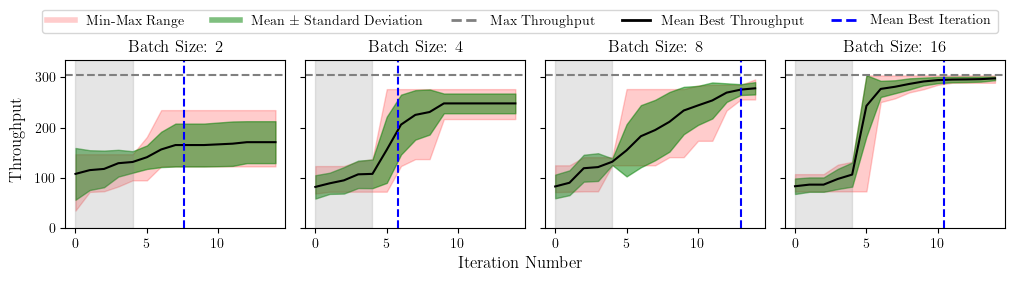

In [85]:
# Plot each old_bo_data in a subplot (averaged)

# set colour cycle for plots
plt.rcParams['axes.prop_cycle'] = plt.cycler(color=plt.cm.gist_rainbow(np.linspace(0, 1, 10)))

# Create a subplot
fig, axes = plt.subplots(1, 4, figsize=(10, 2.5), sharex=True, sharey=True)

# sort the old_bo_data by int
old_bo_data = dict(sorted(old_bo_data.items(), key=lambda item: int(item[1]['batch'])))

# find the maximum inv_rho_inc across all trials and batches
max_rho = 0.0

for i, (batch_name, data) in enumerate(old_bo_data.items()):
    ax = axes[i]

    # concatenate all trials, then compute mean and std of inv_rho_inc by trial_index
    all_trials = pd.concat(data["trial_data"].values(), ignore_index=True)
    summary = (
        all_trials
        .groupby("trial_index")["inv_rho_inc"]
        .agg(['mean', 'min', 'max', 'std'])
        .reset_index()
    )

    # update max_rho if the current batch has a higher max inv_rho_inc
    max_rho = max(max_rho, summary["max"].max())

    # plot mean line
    ax.plot(summary["trial_index"], summary["mean"], color='black')
    
    # fill area between min and max
    ax.fill_between(
        summary["trial_index"],
        summary["min"],
        summary["max"],
        color='red',
        alpha=0.2
    )

    # fill area between mean and std
    ax.fill_between(
        summary["trial_index"],
        summary["mean"] - summary["std"],
        summary["mean"] + summary["std"],
        color='green',
        alpha=0.5
    )
    
    ax.set_title(f"Batch Size: {data['batch']}")

    # Shade warmup trials 0-4
    ax.axvspan(0.0, 4.0, color='gray', alpha=0.2)

    # get the best trial_index per trial, then take their mean
    best_iters = [
        df.groupby('trial_index')['inv_rho_inc']
          .max()
          .idxmax()
        for df in data["trial_data"].values()
    ]
    mean_best = np.mean(best_iters)
    ax.axvline(
        mean_best,
        color='blue',
        linestyle='--',
        label=f'Mean Best Iteration: {mean_best:.1f}'
    )

# add a horizontal line at max_rho
for ax in axes:
    ax.axhline(max_rho, color='gray', linestyle='--', label='Max Throughput')
    ax.set_ylim(0, max_rho * 1.1)  # set y-limits to 10% above max_rho

# shared labels
fig.text(0.5, -0.01, r'Iteration Number', ha='center', fontsize=12)
fig.text(-0.01, 0.5, r'Throughput', va='center', rotation='vertical', fontsize=12)

# Add a legend for red and green areas
handles = [
    plt.Line2D([0], [0], color='red', lw=4, label='Min-Max Range', alpha=0.2),
    plt.Line2D([0], [0], color='green', lw=4, label='Mean ± Standard Deviation', alpha=0.5),
    plt.Line2D([0], [0], color='gray', lw=2, linestyle='--', label='Max Throughput'),
    plt.Line2D([0], [0], color='black', lw=2, label='Mean Best Throughput'),
    plt.Line2D([0], [0], color='blue', lw=2, linestyle='--', label='Mean Best Iteration')
]
fig.legend(handles=handles, loc='upper center', ncol=5, bbox_to_anchor=(0.5, 1.05))

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}old_bo_error_area.pdf", bbox_inches='tight')

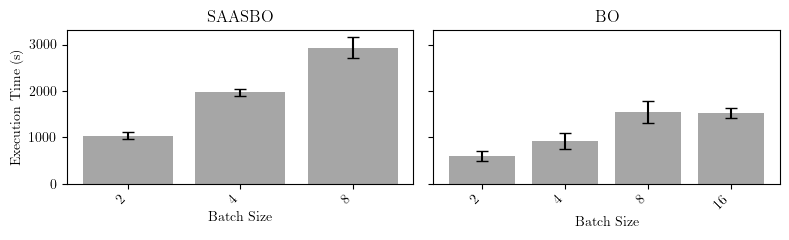

In [111]:
# compute deltas for old_saasbo
old_saasbo_deltas = {}
for name, data in old_saasbo_data.items():
    deltas = []
    for trial, df in data["trial_data"].items():
        start = pd.to_datetime(data["timestamps_data"][trial].iloc[0]["timestamp"])
        end   = pd.to_datetime(data["timestamps_data"][trial].iloc[-1]["timestamp"])
        deltas.append((end - start).total_seconds())
    old_saasbo_deltas[name] = {
        "batch": data["batch"],
        "deltas": deltas
    }

# compute deltas for old_bo
old_bo_deltas = {}
for name, data in old_bo_data.items():
    deltas = []
    for trial, df in data["trial_data"].items():
        start = pd.to_datetime(data["timestamps_data"][trial].iloc[0]["timestamp"])
        end   = pd.to_datetime(data["timestamps_data"][trial].iloc[-1]["timestamp"])
        deltas.append((end - start).total_seconds())
    old_bo_deltas[name] = {
        "batch": data["batch"],
        "deltas": deltas
    }

# build dataframes sorted by batch size
df_saas = pd.DataFrame.from_dict(
    dict(sorted(old_saasbo_deltas.items(), key=lambda x: int(x[1]["batch"]))),
    orient="index"
)
df_bo   = pd.DataFrame.from_dict(
    dict(sorted(old_bo_deltas.items(), key=lambda x: int(x[1]["batch"]))),
    orient="index"
)

# plot side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 2.5), sharey=True)

# Old SaaSBO
x1 = np.arange(len(df_saas))
m1 = df_saas["deltas"].apply(np.mean)
e1 = df_saas["deltas"].apply(np.std)
ax1.bar(x1, m1, yerr=e1, capsize=4, color="gray", alpha=0.7)
ax1.set_title("SAASBO")
ax1.set_xlabel("Batch Size")
ax1.set_xticks(x1)
ax1.set_xticklabels(df_saas["batch"], rotation=45, ha="right")
ax1.set_ylabel("Execution Time (s)")

# Old BO
x2 = np.arange(len(df_bo))
m2 = df_bo["deltas"].apply(np.mean)
e2 = df_bo["deltas"].apply(np.std)
ax2.bar(x2, m2, yerr=e2, capsize=4, color="gray", alpha=0.7)
ax2.set_title("BO")
ax2.set_xlabel("Batch Size")
ax2.set_xticks(x2)
ax2.set_xticklabels(df_bo["batch"], rotation=45, ha="right")

plt.tight_layout()
plt.savefig(f"{FIGURE_SAVE_LOCATION}{FIGURE_PREFILE}batch_deltas_comparison.pdf",
            bbox_inches="tight")
